In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import json

MIN_PASSES_IN_POSSESSION = 3

# Read the data
filenames = glob('data/plays_filtered/*.json')
possessions = []
for filename in tqdm(filenames):
    with open(filename, 'rb') as f:
        possessions_from_file = json.load(f)
    possessions.append(possessions_from_file)

# Flatten the list
possessions = [possession for possession_list in possessions for possession in possession_list]
len(possessions)

  0%|          | 0/29 [00:00<?, ?it/s]

2246

In [4]:
def draw_graph(G_attack: nx.Graph) -> None:
    # Draw the graph (must show node names and weights)
    pos = nx.spring_layout(G_attack)
    nx.draw(G_attack, pos, with_labels=True, connectionstyle='arc3,rad=0.1', arrows=True)
    
    edge_labels = nx.get_edge_attributes(G_attack, 'weight')
    nx.draw_networkx_edge_labels(G_attack, pos, edge_labels=edge_labels)

    plt.show()

In [5]:
# For each possession, create a directed graph from the passes in that possession.
# The nodes are the players, and the edges are the passes.
# The edge weight is the number of times that pass was made.

def compute_attacking_graph(possession, key='CombinedPasses', print_passes=False):
    # Create the the attacking graph for this entire possession
    G_attack = nx.DiGraph()
    
    for pass_ in possession[key]:
        pass_from = pass_['pass_from'] or 'x'
        pass_to = pass_['pass_to'] or 'y'

        if print_passes:
            print(f'{pass_from} --> {pass_to}')
        
        # No self-loops
        if pass_from == pass_to:
            continue

        # If this edge already exists, increase the weight by one, else add it
        if G_attack.has_edge(pass_from, pass_to):
            G_attack[pass_from][pass_to]['weight'] += 1
        else:
            G_attack.add_edge(pass_from, pass_to, weight=1)
    
    if print_passes:
        print('---')

    return G_attack


In [ ]:
# Just for visualization, let's pick a random possession and draw the graph for it
import random

i = random.randint(0, len(possessions))
possession = possessions[i]
ag1 = compute_attacking_graph(possession, key='Passes')
ag2 = compute_attacking_graph(possession, key='CombinedPasses')

draw_graph(ag1)
draw_graph(ag2)

In [7]:
# Compute various metrics for the attacking graph

metric_labels_att = ['max_bwn_c', 'recip', 'triangles', 'numpasses']

def compute_metrics_on_attacking_graph(G_attack):
    results = pd.Series(index=metric_labels_att, dtype=float)
    results['max_bwn_c'] = max(nx.betweenness_centrality(G_attack).values())
    results['recip'] = nx.reciprocity(G_attack)
    results['triangles'] = sum(nx.triangles(nx.Graph(G_attack)).values()) // 3
    # sum of all edge weights (number of passes)
    results['numpasses'] = sum([G_attack[u][v]['weight'] for u, v in G_attack.edges()])
    
    return results

In [8]:
def compute_defending_team_for_possession(possession):
    #### Figure out which one is the defending team ####
    # Go through all the passes, see who made the pass, compute the team of this player, take the majority

    passee_team_for_each_pass = [] # "passee" = person who receives the pass
    
    for pass_ in possession['CombinedPasses']:
        
        snapshot = pass_['snapshots'][0]
        home_players = [player for player in snapshot['HomePlayers'].keys()]
        guest_players = [player for player in snapshot['GuestPlayers'].keys()]
        
        pass_to_team = None
        pass_to = pass_['pass_to']
        if pass_to in home_players:
            pass_to_team = 'home'
        elif pass_to in guest_players:
            pass_to_team = 'guest'
        else:
            pass_to_team = 'unknown'
        passee_team_for_each_pass.append(pass_to_team)
    
    defending_team = None

    # Sanity check: if this possession had equal-ish passees from both teams, then something is wrong
    passee_team_for_each_pass = pd.Series(passee_team_for_each_pass)
    num_home_passes = passee_team_for_each_pass.value_counts().get('home', 0)
    num_guest_passes = passee_team_for_each_pass.value_counts().get('guest', 0)
    if abs(num_home_passes - num_guest_passes) <= 2:
        defending_team = 'unknown'
    else:
        defending_team = passee_team_for_each_pass.value_counts().sort_values().index[0]

    return(defending_team)

In [9]:
def create_defensive_graphs_for_possession(possession):

    defending_team = compute_defending_team_for_possession(possession)
    if defending_team == 'unknown':
        return None

    # For each pass in the possession, get the defensive team's positions
    player_positions_key = 'HomePlayers' if defending_team == 'home' else 'GuestPlayers'
    defensive_graphs = []
    
    for pass_ in possession['CombinedPasses']:
        defending_team_positions = pass_['snapshots'][0][player_positions_key]
        ball_position = pass_['snapshots'][0]['Ball']

        # Create a graph with players as nodes and distance between them as edge lengths
        # Also add the ball as a node, and an edge between the ball and every player
        G = nx.Graph()
        G.add_node('ball')
        for player_name in defending_team_positions:
            G.add_node(player_name)
            # Add edge between this player and the ball
            player = defending_team_positions[player_name]
            distance = np.round(np.sqrt((player['x'] - ball_position['x'])**2 + (player['y'] - ball_position['y'])**2), 2)
            G.add_edge(player_name, 'ball', weight=distance)
        
        for player_name in defending_team_positions:
            player = defending_team_positions[player_name]
            for other_player_name in defending_team_positions:
                other_player = defending_team_positions[other_player_name]
                if player_name != other_player_name:
                    distance = np.round(np.sqrt((player['x'] - other_player['x'])**2 + (player['y'] - other_player['y'])**2), 2)
                    G.add_edge(player_name, other_player_name, weight=distance)
    
        # draw_graph(G)
        defensive_graphs.append(G)
    
    return defensive_graphs

In [10]:
# Compute various metrics for the defensive graph

metric_labels_def = ['def_max_pagerank', 'def_dist_from_ball', 'def_edge_sum']

def compute_metrics_on_defensive_graph(G_defense):
    results = pd.Series(index=metric_labels_def, dtype=float)
    results['def_max_pagerank'] = max(nx.pagerank(G_defense).values())
    results['def_dist_from_ball'] = sum([G_defense[u][v]['weight'] for u, v in G_defense.edges() if u == 'ball']) / (G_defense.number_of_nodes()-1)
    # sum of all edge weights
    results['def_edge_sum'] = sum([G_defense[u][v]['weight'] for u, v in G_defense.edges()])
    
    return results

In [ ]:
# Create data for Jonathan

from networkx.readwrite import json_graph
import json

possessions_for_jonathan = []

for possession in tqdm(possessions):

    G_attack = compute_attacking_graph(possession)
    Gs_defense = create_defensive_graphs_for_possession(possession)
    if Gs_defense is None: # defending team is unknown
        continue
    
    possession['attacking_graph'] = json_graph.node_link_data(G_attack)
    possession['defensive_graphs'] = [json_graph.node_link_data(G_defense) for G_defense in Gs_defense]

    possessions_for_jonathan.append(possession)

with open('data/possessions_for_jonathan.json', 'w') as f:
    json.dump(possessions_for_jonathan, f)

In [29]:
rows = []
used_possessions = []
possesion_lengths = []

for possession in tqdm(possessions):
    
    G_attack = compute_attacking_graph(possession)
    # draw_graph(G_attack)

    # sum of all edge weights (number of passes)
    possession_length = sum([G_attack[u][v]['weight'] for u, v in G_attack.edges()])
    possesion_lengths.append(possession_length)

    # If there's too few passes in this possession, skip it
    if possession_length < 3:
        continue

    Gs_defense = create_defensive_graphs_for_possession(possession)
    if Gs_defense is None: # defending team is unknown
        continue
    
    # Now we have both graphs, we can compute metrics for both
    
    # Compute metrics for attacking graph
    metrics_att = compute_metrics_on_attacking_graph(G_attack)
    metrics_def = []

    # With defensive graphs, it's complicated because there are multiple graphs.
    # Compute the metrics for the first, middle, and last pass in the possession.
    for (i, G_defense) in enumerate([Gs_defense[0], Gs_defense[len(Gs_defense)//2], Gs_defense[-1]]):
        metrics_def_i = compute_metrics_on_defensive_graph(G_defense)
        metrics_def_i.index = [f'{label}_{i}' for label in metrics_def_i.index]
        metrics_def.append(metrics_def_i)
        # draw_graph(G_defense)
    
    metrics_def = pd.concat(metrics_def)
    row = pd.concat([metrics_att, metrics_def])
    # Add the label
    row['label'] = possession['Weight']
    rows.append(row)
    used_possessions.append(possession)
    

  0%|          | 0/2246 [00:00<?, ?it/s]

In [31]:
# Lengths of possessions
pl = pd.Series(possesion_lengths)
pl.value_counts()

0     806
1     435
2     365
3     260
4     176
5      92
6      72
7      23
8      10
9       4
10      3
dtype: int64

In [ ]:
# Just visualization to see that everything is alright
import random

i = random.randint(0, len(used_possessions))
poss = used_possessions[i]
a = compute_attacking_graph(poss, print_passes=True)
d = create_defensive_graphs_for_possession(poss)

draw_graph(a)
for g in d:
    draw_graph(g)

In [110]:
df = pd.DataFrame(rows)
df

,max_bwn_c,recip,triangles,numpasses,def_max_pagerank_0,def_dist_from_ball_0,def_edge_sum_0,def_max_pagerank_1,def_dist_from_ball_1,def_edge_sum_1,def_max_pagerank_2,def_dist_from_ball_2,def_edge_sum_2,label
0,0.833333,0.666667,1.0,6.0,0.218140,18.610,364.67,0.234217,16.288,300.71,0.191331,18.886,316.81,3.0
1,0.666667,1.000000,0.0,8.0,0.281299,13.584,293.28,0.227048,16.444,315.71,0.246012,14.540,276.05,2.0
2,0.500000,0.666667,0.0,3.0,0.267663,13.410,282.91,0.265868,20.420,308.26,0.187089,19.550,304.93,2.0
3,0.500000,0.800000,1.0,5.0,0.241715,28.116,423.30,0.225133,17.418,331.74,0.192676,19.366,339.12,2.0
4,1.000000,1.000000,0.0,4.0,0.213784,17.608,298.70,0.214694,21.752,371.32,0.215725,21.460,397.65,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,0.500000,0.000000,1.0,3.0,0.292486,18.766,317.39,0.312329,17.914,346.31,0.221619,20.018,340.12,2.0
635,0.833333,0.400000,1.0,6.0,0.206843,23.722,437.78,0.195755,21.022,339.70,0.192641,22.458,365.86,3.0
636,0.500000,0.000000,2.0,5.0,0.199046,23.532,433.77,0.234562,16.806,322.99,0.254023,13.672,276.04,1.0
637,0.666667,0.333333,2.0,6.0,0.195384,22.426,419.18,0.209296,17.320,312.43,0.203554,17.676,360.12,1.0


In [78]:
df['label'].value_counts()

 2.0    309
 3.0    190
-1.0     84
 1.0     56
Name: label, dtype: int64

In [111]:
BINARY_CLASSIFICATION = True

# Convert the label columns to a binary class: 1 if >= 3 and 0 if <0
if BINARY_CLASSIFICATION:
    df['label'] = df['label'].apply(lambda x: 1 if x >= 3 else 0)

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Split the data into predictor variables (X) and label (y)
X = df.drop('label', axis=1)
y = df['label']

In [113]:
# Create the classification model
if BINARY_CLASSIFICATION:
    models = {
        'attk': LogisticRegression(),
        'defe': LogisticRegression(),
        'both': LogisticRegression()
    }
else:
    models = {
        'attk': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        'defe': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        'both': LogisticRegression(multi_class='multinomial', solver='lbfgs')
    }

accuracies = {
    'attk': [],
    'defe': [],
    'both': []
}

for model_name, model in models.items():

    for i in tqdm(range(10)):

        # Split the data into training and testing sets with a 90-10 split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

        # Scale the data
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        training_column_names = {
            'attk': [col for col in X_train_scaled.columns if 'def' not in col],
            'defe': [col for col in X_train_scaled.columns if 'def' in col],
            'both': [col for col in X_train_scaled.columns]
        }
        
        # Fit the model to the training data
        model.fit(X_train_scaled[training_column_names[model_name]], y_train)

        # Predict the labels for the test data
        y_pred = model.predict(X_test_scaled[training_column_names[model_name]])

        # Evaluate the model's performance
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[model_name].append(accuracy)
        # report = classification_report(y_test, y_pred)

# # Print the results
# print(f"Model: {model_name}")
# print(f"Accuracy: {accuracy}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

attk: 0.675
defe: 0.690625
both: 0.6953125


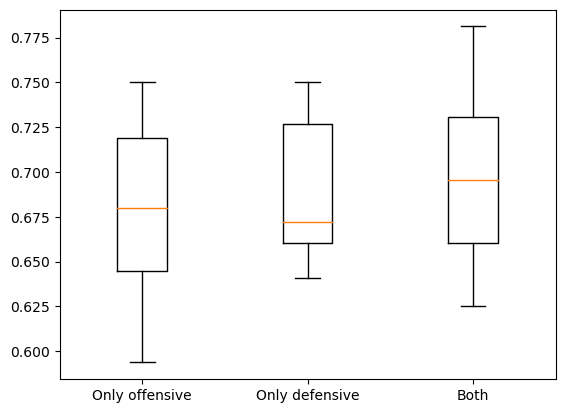

In [114]:
for model_name, accuracy_list in accuracies.items():
    print(f'{model_name}: {np.mean(accuracy_list)}')

# Plot the results: box plots, one for each model, with the accuracies for that model
plt.boxplot(accuracies.values(), labels=['Only offensive', 'Only defensive', 'Both'])
plt.show()

In [121]:
# Get the coefficients
coefficients = models['both'].coef_

# Create a DataFrame for easy viewing
coeff_df = pd.DataFrame(coefficients, columns=X_train.columns)

if not BINARY_CLASSIFICATION:
    # Transpose the DataFrame for easier viewing
    coeff_df = coeff_df.T

    # Add the class labels as column names
    coeff_df.columns = models['both'].classes_

# Print the DataFrame
coeff_df

,max_bwn_c,recip,triangles,numpasses,def_max_pagerank_0,def_dist_from_ball_0,def_edge_sum_0,def_max_pagerank_1,def_dist_from_ball_1,def_edge_sum_1,def_max_pagerank_2,def_dist_from_ball_2,def_edge_sum_2
0,0.10968,-0.211663,-0.167252,0.145235,0.048234,-0.074143,0.119267,-0.015276,0.133933,-0.107068,0.140725,0.860761,-0.453397


In [120]:
import statsmodels.api as sm

# Add a constant to the features
X2 = sm.add_constant(X)

# Fit the model
model = sm.Logit(y, X2)
result = model.fit()

# Print the summary table
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.574920
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                  639
Model:                          Logit   Df Residuals:                      625
Method:                           MLE   Df Model:                           13
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                 0.05533
Time:                        00:39:39   Log-Likelihood:                -367.37
converged:                       True   LL-Null:                       -388.89
Covariance Type:            nonrobust   LLR p-value:                 4.432e-05
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.9967      1.630     -3.065      0.002      -8.192      -1.802